In [31]:
def fill_by_average(prev_data):
    final_data=[]
    for i,item in enumerate(prev_data):
        final_data.append(item)
        if i<len(prev_data)-1:
            final_data.append((item+prev_data[i+1])/2)
    return final_data
from sklearn import preprocessing

def fft_from_data_frame(data_frame,fs=1e6):
    signal_set = []
    for index, row in data_frame.iterrows():
        fft_data = fft(row, n=row.size)/row.size
        freq = fftfreq(row.size, d=1/fs)
        cut_high_signal = np.abs(fft_data).copy()
        cut_high_signal[(freq > 50000)] = 0
        cut_high_signal[(freq < 30000)] = 0
        d = np.abs(cut_high_signal)
#         d  = list(filter(lambda a: a != 0, d))
        while len(d) < 80:
            d = fill_by_average(d) 
        if len(d) == 81:
            d.insert(41,(d[0]+d[len(d)-1])/2)
        signal_set.append(d)
    return signal_set

4095
ee


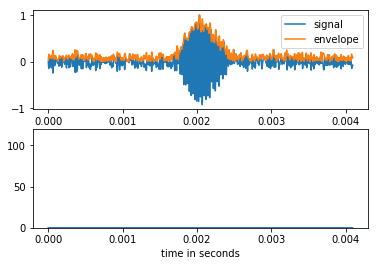

In [23]:
from scipy.signal import hilbert, chirp
def hilbert_transform(data_frame,fs=1e6):
    signal_set = []
    for index, signal in data_frame.iterrows():
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = (np.diff(instantaneous_phase)/((2.0*np.pi) * fs))
        print(len(instantaneous_frequency))
        signal_set.append(analytic_signal)
        t = np.arange(4096) / 1e6
        fig = plt.figure()
        ax0 = fig.add_subplot(211)
        ax0.plot(t, signal, label='signal')
        ax0.plot(t, amplitude_envelope, label='envelope')
        ax0.set_xlabel("time in seconds")
        ax0.legend()
        ax1 = fig.add_subplot(212)
        ax1.plot(t[1:], instantaneous_frequency)
        ax1.set_xlabel("time in seconds")
        ax1.set_ylim(0.0, 120.0)
        return
    return signal_set
hilbert_transform(stopper_data)
print('ee')

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from numpy.fft import fft, fftfreq, ifft, rfft

stopper_data = pd.read_csv('./data/train/Stopper/_80cm_AS_00008.csv', header=None)
stopper_data_2 = pd.read_csv('./data/train/Stopper/100cm_AS_00003.csv', header=None)
wall_data = pd.read_csv('./data/train/Wall_Collection/_80cm_AS_00002.csv', header=None)
wall_data_2 = pd.read_csv('./data/train/Wall_Collection/100cm_AS_00005.csv', header=None)

predict_stopper_data = pd.read_csv('./data/predict/Stopper/100cm_AS_00003.csv', header=None)
predict_wall_data = pd.read_csv('./data/predict/Wall_Collection/_80cm_AS_00002.csv', header=None)

In [37]:
stopper_fft = fft_from_data_frame(stopper_data) + fft_from_data_frame(stopper_data_2)
wall_fft = fft_from_data_frame(wall_data)+ fft_from_data_frame(wall_data_2)
predict_stopper_fft = fft_from_data_frame(predict_stopper_data)
predict_wall_fft = fft_from_data_frame(predict_wall_data)
X = stopper_fft + wall_fft
y = [0]*len(stopper_fft) + [1]*len(wall_fft)
predict_X = predict_stopper_fft + predict_wall_fft
y_true = [0]*len(predict_stopper_fft) + [1]*len(predict_wall_fft)

In [388]:
#all files
# stopper_data = pd.read_csv('./data/all/Stopper_train_80_to_180.csv', header=None)
# wall_data = pd.read_csv('./data/all/Wall_Collection_train_80_to_180.csv', header=None)
# predict_stopper_data = pd.read_csv('./data/all/Stopper_predict_80_to_180.csv', header=None)
# predict_wall_data = pd.read_csv('./data/all/Wall_Collection_predict_80_to_180.csv', header=None)


stopper_data = pd.read_csv('./final_data/Step_train_aggregate.csv', header=None)
wall_data = pd.read_csv('./final_data/Wall_train_aggregate.csv', header=None)
predict_stopper_data = pd.read_csv('./final_data/Step_predict_aggregate.csv', header=None)
predict_wall_data = pd.read_csv('./final_data/Wall_predict_aggregate.csv', header=None)

#get fft
stopper_fft = fft_from_data_frame(stopper_data)
wall_fft = fft_from_data_frame(wall_data)
X = stopper_fft + wall_fft
y = [11]*len(stopper_fft) + [2]*len(wall_fft)

#predictions
predict_stopper_fft = fft_from_data_frame(predict_stopper_data)
predict_wall_fft = fft_from_data_frame(predict_wall_data)
predict_X = predict_stopper_fft + predict_wall_fft
y_true = [0]*len(predict_stopper_fft) + [1]*len(predict_wall_fft)

In [5]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(7,), random_state=1)
clf.fit(X, y)
print(len(predict_wall_fft[0]))
result = clf.predict(predict_wall_fft)
print(result)

NameError: name 'predict_wall_fft' is not defined

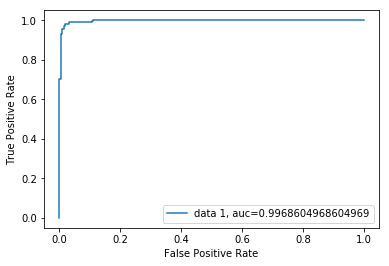

In [276]:
from sklearn import metrics
pred = clf.predict_proba(predict_X)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_true, pred)
auc = metrics.roc_auc_score(y_true, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[[190   8]
 [  4 218]]


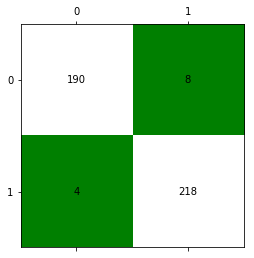

In [293]:
y_pred = clf.predict(predict_X)

# confusion metrics
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['g', 'w'])

cm = confusion_matrix(y_true, y_pred)

plt.matshow(cm, cmap=cmap)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        c = cm[j,i]
        plt.text(i, j, str(c), va='center', ha='center')
print(cm)

In [354]:
for i in range(1,10):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i,), random_state=1)
    clf.fit(X, y)
    result = clf.predict(predict_X)

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
# stopper_data = pd.read_csv('./final_data/Step_Overall.csv', header=None)
# wall_data = pd.read_csv('./final_data/Wall_Overall.csv', header=None)
stopper_data = pd.read_csv('./final_data/Stopper_overall_80to270.csv', header=None)
wall_data = pd.read_csv('./final_data/Wall_Collection_overall_80to270.csv', header=None)

#get fft
stopper_fft = fft_from_data_frame(stopper_data, fs=1e6)
wall_fft = fft_from_data_frame(wall_data, fs=1e6)

X = stopper_fft + wall_fft
X = preprocessing.normalize(X)
y = [0]*len(stopper_fft) + [1]*len(wall_fft)
max_average = 0 
index = 0
index_2 = 0

for j in range(1, 10):
    for i in range(1,50):
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i,j,), random_state=1)
        scores = cross_val_score(clf, X, y, cv=8, scoring="accuracy")
    #     print("hidden layer", i, "score average", scores.mean())
        if max_average < scores.mean():
            max_average = scores.mean()
            index = i
            index_2 = j
print("1 hidden layer:",index, "2 hidden layer:", index_2, "and max accuracy score: ",max_average)

1 hidden layer: 15 2 hidden layer: 6 and max accuracy score:  0.8954282263372098


In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

# kf = KFold(n_splits=8)
kf = KFold(n_splits=10, shuffle=True)
from sklearn import metrics
max_average = 0 
index = 0
index_2 = 0
y = np.array(y)
for j in range(1, 10):
    for i in range(1,50):
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i,j,), random_state=1)
        score = np.array([])
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train,y_train)
            y_clf_result = clf.predict(X_test)
            score = np.append(score, [accuracy_score(y_clf_result, y_test)])
        if max_average < np.average(score):
            max_average = np.average(score)
            index = i
            index_2 = j
print("1 hidden layer:",index, "2 hidden layer:", index_2, "and max accuracy score: ",max_average)

1 hidden layer: 15 2 hidden layer: 3 and max accuracy score:  0.9285714285714286


In [399]:

for n in normalized_X:
    print(n)

[0.5 0.5 0.5 0.5]
[0.18257419 0.36514837 0.54772256 0.73029674]


In [43]:
from sklearn import preprocessing
a = preprocessing.normalize(stopper_fft)
print(a.shape)

104
(104, 4096)


In [ ]:
[1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2]